In [1]:
!pip install -q lifelines

生存分析のいろいろに踏み込んでみる

### Kaplan-Meier
いつもの。生存曲線S(t)を求める向け。ただし、瞬間生存率は無理(後述するNelsonと同じだと思うのだが...)

In [2]:
import numpy as np
import pandas as pd
# visualize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_formats = {'png', 'retina'}

In [3]:
from lifelines.datasets import load_dd
from lifelines import KaplanMeierFitter

data = load_dd()
data.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


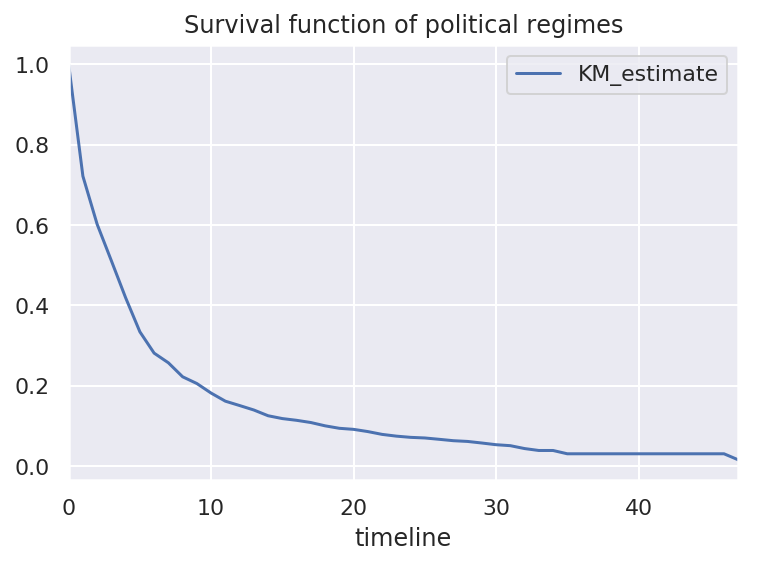

In [4]:
kmf = KaplanMeierFitter()
T = data["duration"]
E = data["observed"]

kmf.fit(T, event_observed=E)
kmf.survival_function_.plot()
plt.title('Survival function of political regimes');

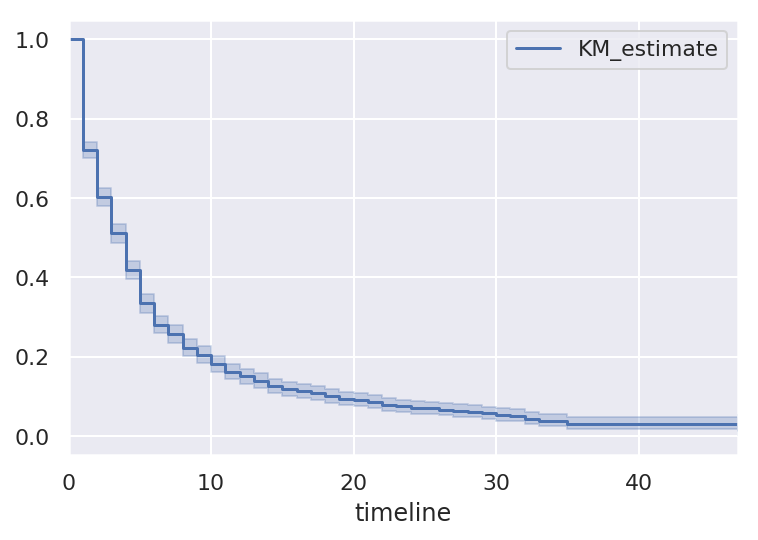

In [5]:
kmf.plot() #信頼区間も出せる

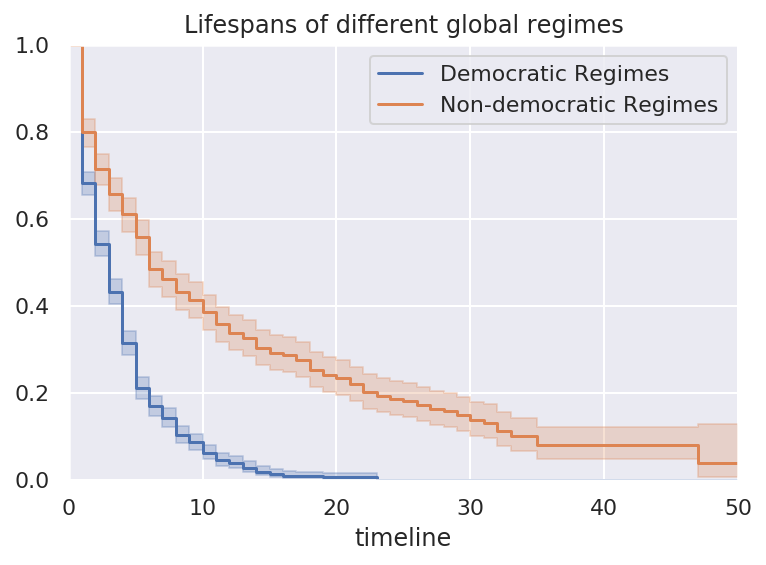

In [6]:
# コホートで分けて書いてみよう
ax = plt.subplot(111)
dem = (data["democracy"] == "Democracy")
t = np.linspace(0, 50, 51)

kmf.fit(T[dem], event_observed=E[dem],timeline=t, label="Democratic Regimes")
kmf.plot(ax=ax)

kmf.fit(T[~dem], event_observed=E[~dem],timeline=t, label="Non-democratic Regimes")
kmf.plot(ax=ax)

plt.ylim(0, 1);
plt.title("Lifespans of different global regimes");
# 民主主義のほうが短命

In [7]:
# logrank_testで検定もできるよ #詳しくは別のノートブックで
from lifelines.statistics import logrank_test
results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=.99)
results.print_summary()

### Nelson-Aalen
Kaplan-Meierとと違って瞬間死亡率が計算できる。

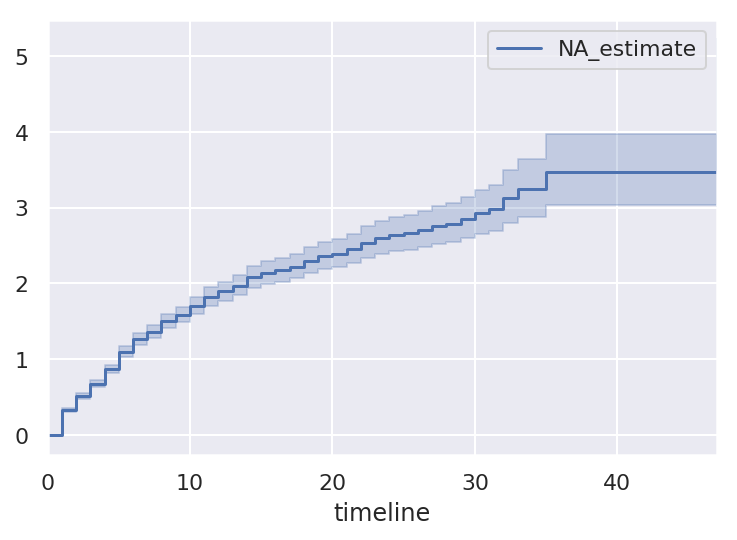

In [8]:
from lifelines import NelsonAalenFitter

T = data["duration"]
E = data["observed"]
naf = NelsonAalenFitter()
naf.fit(T,event_observed=E)
naf.plot() #これは累積死亡率(H(t))のグラフ解釈は難しいだろう

`plot_hazard`で瞬間死亡率を描画できる。bandwidthを入れることでsmoothingできる。

(-0.01, 0.5)

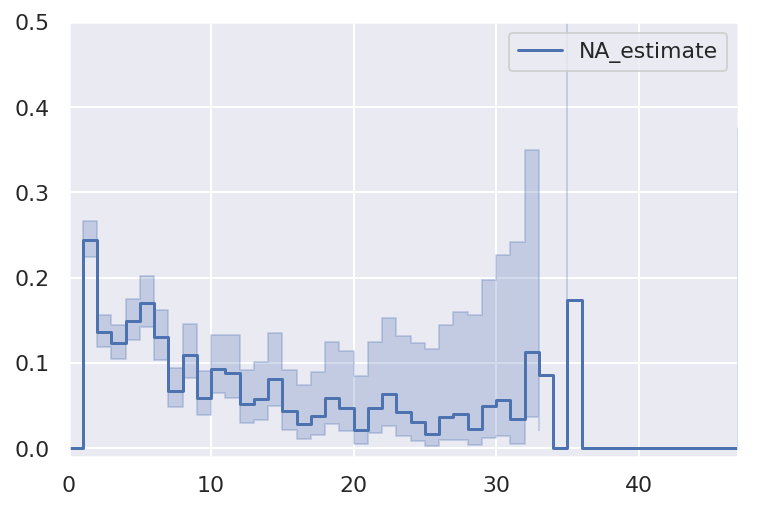

In [9]:
naf.plot_hazard(bandwidth=1)
plt.ylim(-0.01,0.5)

(-0.01, 0.5)

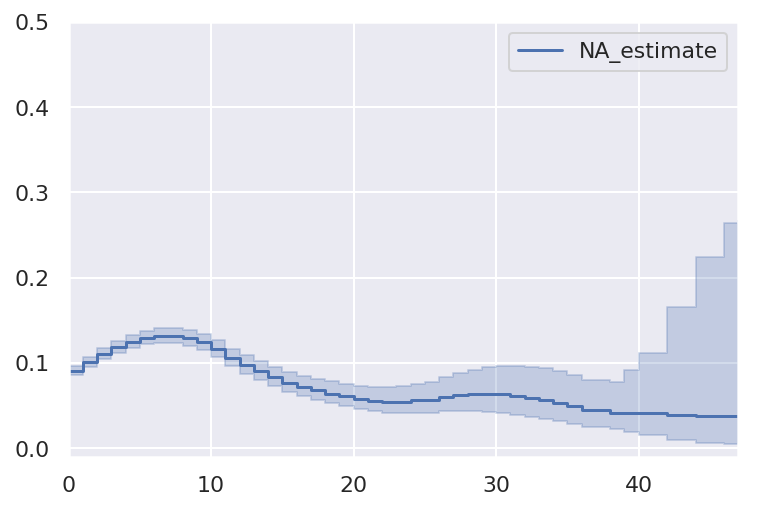

In [10]:
naf.plot_hazard(bandwidth=10)
plt.ylim(-0.01,0.5)

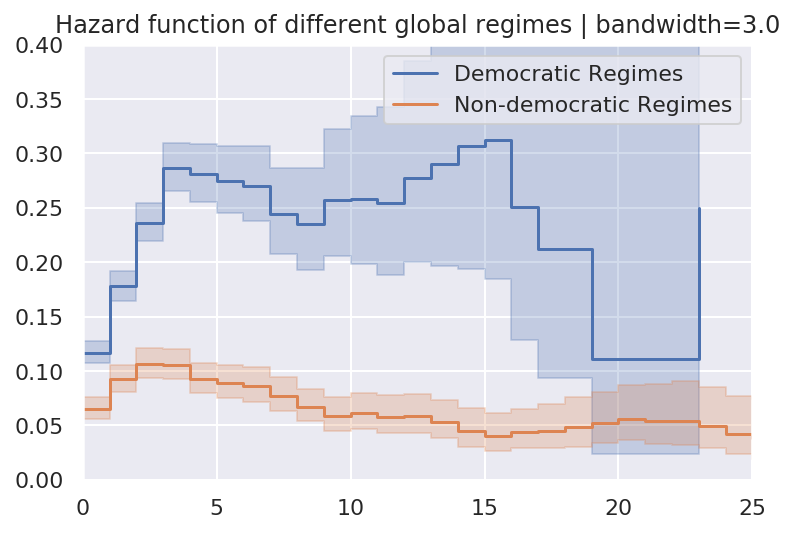

In [11]:
bandwidth = 3.

naf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax = naf.plot_hazard(bandwidth=bandwidth)

naf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
naf.plot_hazard(ax=ax, bandwidth=bandwidth)

plt.title("Hazard function of different global regimes | bandwidth=%.1f" % bandwidth);
plt.ylim(0, 0.4)
plt.xlim(0, 25);

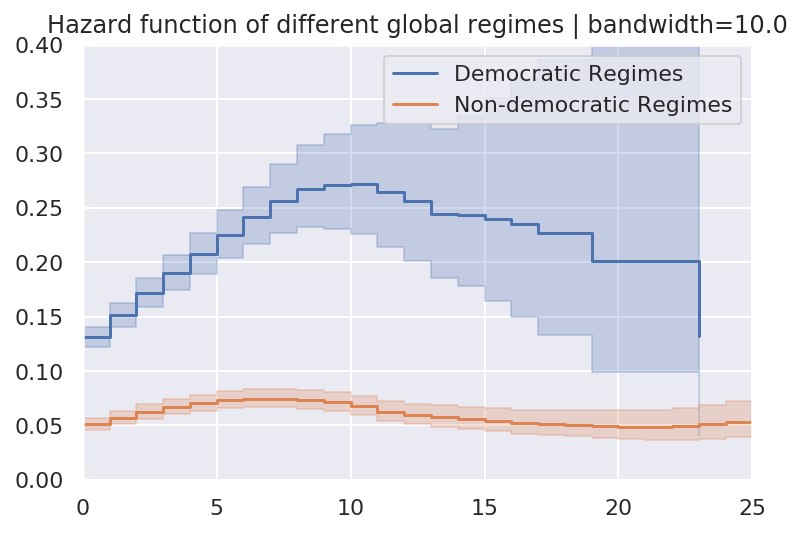

In [12]:
bandwidth = 10

naf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax = naf.plot_hazard(bandwidth=bandwidth)

naf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
naf.plot_hazard(ax=ax, bandwidth=bandwidth)

plt.title("Hazard function of different global regimes | bandwidth=%.1f" % bandwidth);
plt.ylim(0, 0.4)
plt.xlim(0, 25);

### Weibull model
生存時間Tにワイブル分布を仮定したモデル。式をごちゃごちゃすると合うのでわからなくなったら式変形してみよう。

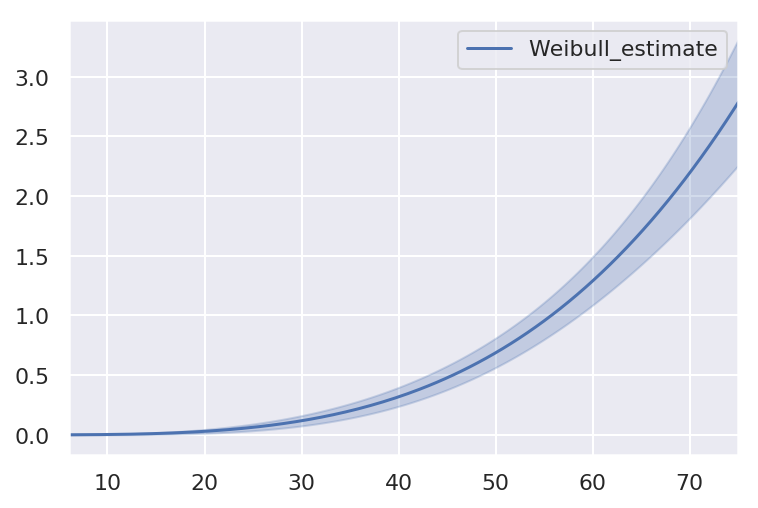

In [13]:
from lifelines import WeibullFitter
from lifelines.datasets import load_waltons

data = load_waltons()

T = data['T']
E = data['E']

wf = WeibullFitter().fit(T, E)

wf.print_summary() #どれぐらいfitしているのか知りてぇ
wf.plot() #これも累積死亡率H(t)を推定している。

### モデル選択
QQplotとAICを用いたモデル選択のexampleを別のnotebookに示すよ

### Left censored and non-detection
省略

### Left truncated (late entry) data
(我々のデータではそういう状況はないけど、)調査段階に入る前に死亡している場合、調査には参加できないけどdurationは短い結果が得られているはず。そういうサンプルが多いと調査では長めの生存時間が得られてしまう。

具体例→AIDSになった人の平均寿命調査。AIDSになってから4年後に研究に参加した人がいるとする。そういう人をすでに4年生きた扱いにすると、それまでに死んだ人たちを考慮できない(AIDSになって研究までに死んだ人たちは研究には参加できないのだから)。

バイアスはこんぐらいある

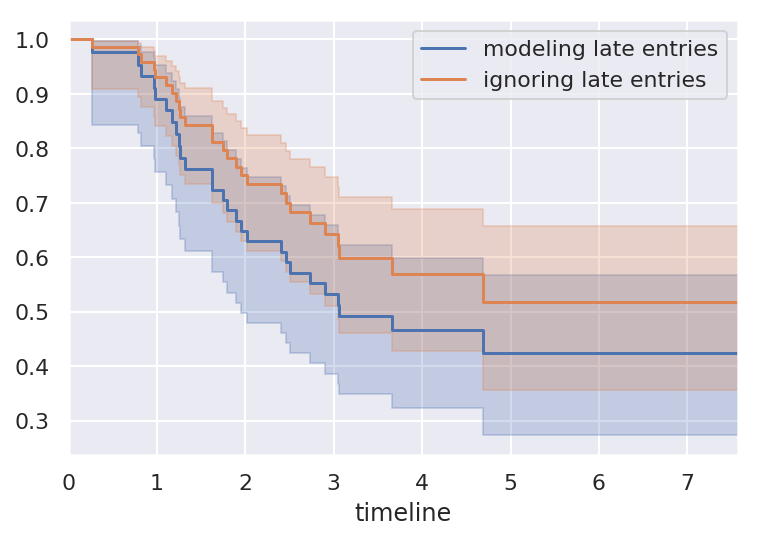

In [14]:
from lifelines.datasets import load_multicenter_aids_cohort_study
df = load_multicenter_aids_cohort_study()

kmf = KaplanMeierFitter()
kmf.fit(df["T"], event_observed=df["D"], entry=df["W"], label='modeling late entries')
ax = kmf.plot()

kmf.fit(df["T"], event_observed=df["D"], label='ignoring late entries')
kmf.plot(ax=ax)